In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
plt.rc("figure", **{"figsize": (16,10)})
np.random.seed(27182)
pd.options.display.float_format = '{:,.2f}'.format

from ou_market_making import OrnsteinUhlenbeck, PriceProcess, MeanRevertingStrategy, round_to

# Intuition

#### Ornstein–Uhlenbeck Process

$$\begin{aligned}
    \text{The }&\text{continuous case:} \\
    dX_t &= \theta(\mu-X_t)dt + \sigma dB_t \\
    X_{t_{i+1}} &= X_{t_i} + \int_{t_i}^{t_{i+1}} \theta(\mu-X_s)ds + \int_{t_i}^{t_{i+1}} \sigma dB_s \\
    \text{The }&\text{discrete case:} \\
    \Delta X_{t_i} &= \theta(\mu-X_{t_i})\Delta t + \sigma \sqrt{\Delta t} \Delta B_{t_i} \\
    X_{t_{i+1}} &= X_{t_i} + \Delta X_{t_i}
\end{aligned}$$

$\mu$ is the "mean" of the process, AKA the long-run expectation.

$\theta$ is the mean reversion strength. What happens when $\theta \to 0$? $\theta \to \infty$?

What is $Var[B_t]$ as $t \to \infty$? $Var[X_t]$ as $t \to \infty$?

What process behaves opposite to an OU Process?

Is trading an OU Process more or less beneficial for market making?

In [2]:
# GLOBALS

N_STEPS = int(1e3)
X0 = 10
X0 = 0

TICKSIZE = 0.1

# Set up parameters from above
theta  = 7
mu     = X0
sigma  = 3
deltat = 1e-2

ou = OrnsteinUhlenbeck(X0, theta, mu, sigma, deltat)
pripro = PriceProcess(ou, TICKSIZE)

pripro.generate(N_STEPS)

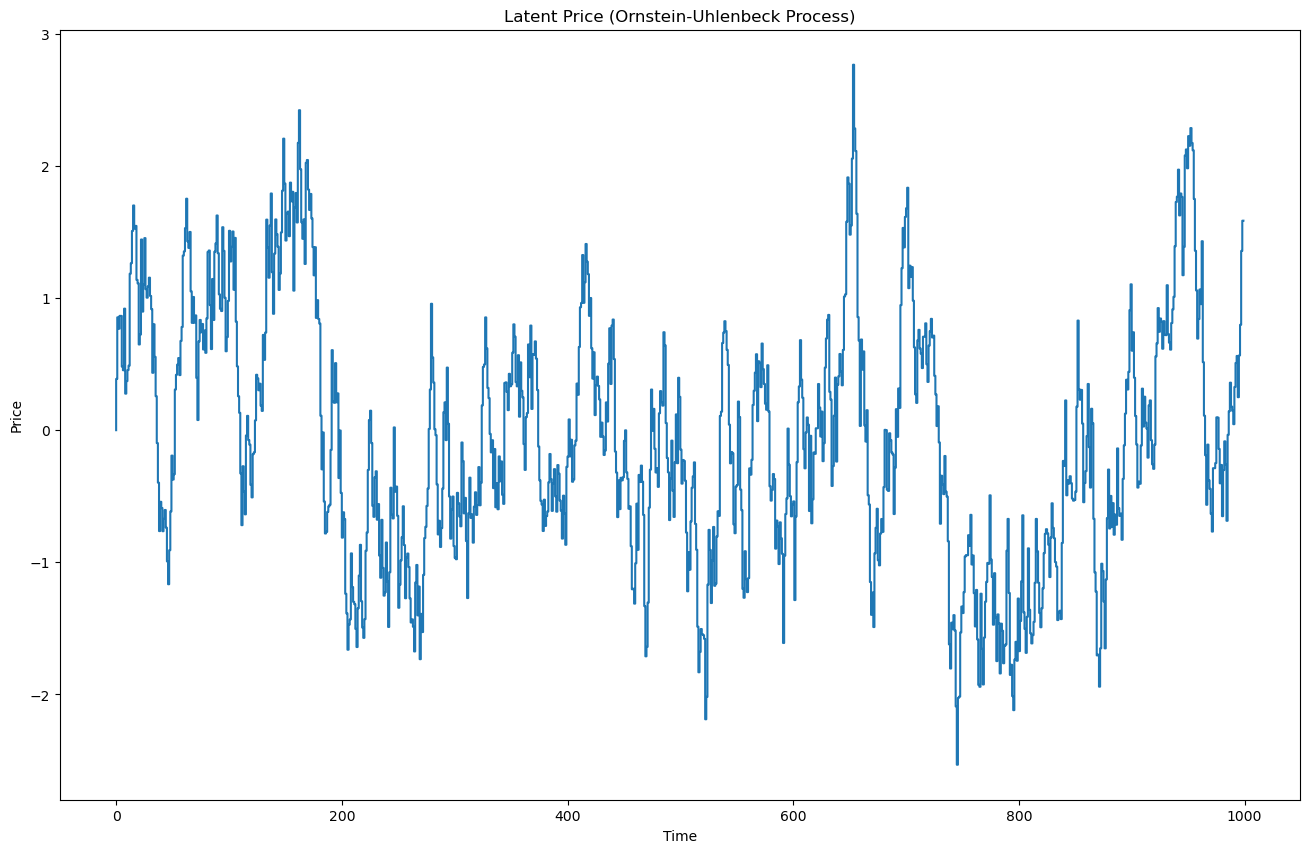

In [3]:
N_FIRST = 50

slice = pripro.time < N_FIRST
temp_latent_price = pripro.latent_price[slice]
lo, hi = temp_latent_price.min(), temp_latent_price.max()

fig, axis = plt.subplots()

pripro.plot_latent_price(axis)
# axis.add_patch(Rectangle((0, lo), N_FIRST, hi-lo, edgecolor='r', fill=False))

plt.show()

"Latent Price" := fair price that is NOT observable.

How is the OU Process different from Brownian Motion? From Geometric Brownian Motion?

Is this a Markov process (the future distribution is only conditional on the current value and having the full path history does not improve estimates)?

Is this a Martingale (the future expectation is the current value)?

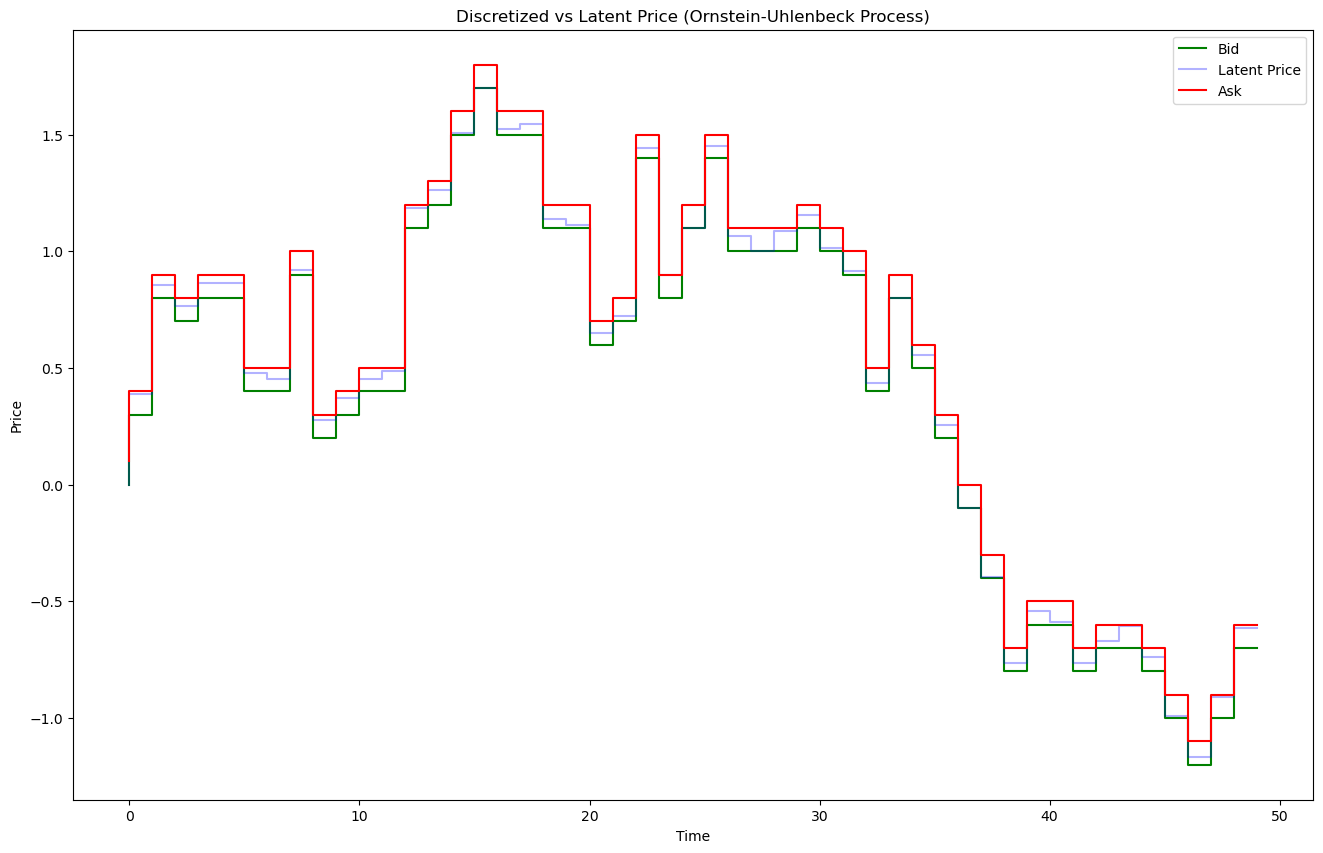

In [4]:
fig, axis = plt.subplots()

pripro.plot_bid_ask(axis, slice)

plt.show()

What is the tick size?

# Intuition

Given the difference equation, we can estimate where 

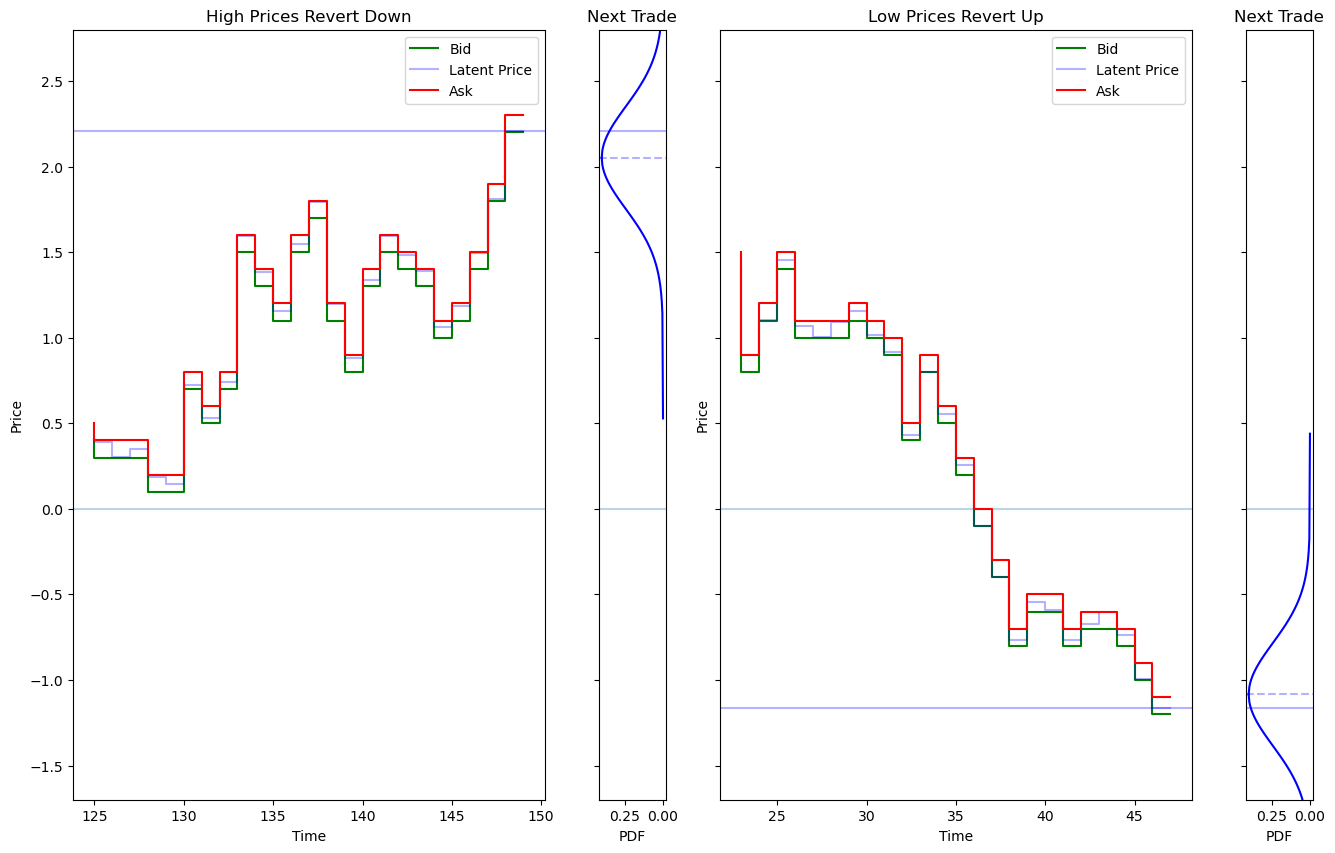

In [5]:
slice = N_FIRST / 2

hi_bound = X0 + 20*TICKSIZE
lo_bound = X0 - 10*TICKSIZE

hi_loc = np.argmax(pripro.latent_price>hi_bound)
lo_loc = np.argmax(pripro.latent_price<lo_bound)
hi_latent = pripro.latent_price[hi_loc]
lo_latent = pripro.latent_price[lo_loc]

fig, axs = plt.subplots(1, 4, gridspec_kw={"width_ratios": [7,1,7,1]}, sharey=True)

for axx in axs:
    axx.axhline(X0, alpha=0.3)

pripro.plot_bid_ask(axs[0], (hi_loc-slice < pripro.time) & (pripro.time <= hi_loc))
# axs[0].axhline(hi_bound, color='r', alpha=0.5)
axs[0].axhline(hi_latent, color='b', alpha=0.3)
axs[0].set(title="High Prices Revert Down")

pripro.dynamics.plot_next_pdf(axs[1], hi_latent)
# axs[1].axhline(hi_bound, color='r', alpha=0.5)
axs[1].axhline(hi_latent, color='b', alpha=0.3)
axs[1].set(title="Next Trade", xlabel="PDF")

pripro.plot_bid_ask(axs[2], (lo_loc-slice < pripro.time) & (pripro.time <= lo_loc))
# axs[2].axhline(lo_bound, color='g', alpha=0.5)
axs[2].axhline(lo_latent, color='b', alpha=0.3)
axs[2].set(title="Low Prices Revert Up")

pripro.dynamics.plot_next_pdf(axs[3], lo_latent)
# axs[3].axhline(lo_bound, color='g', alpha=0.5)
axs[3].axhline(lo_latent, color='b', alpha=0.3)
axs[3].set(title="Next Trade", xlabel="PDF")

axs[0].set_ylabel("Price")
axs[3].set_ylim([pripro.bid_price[lo_loc]-5*TICKSIZE, pripro.ask_price[hi_loc]+5*TICKSIZE])
plt.show()

"Latent Price" is NOT observable. What is a good estimate for fair price if we ONLY have Bid and Ask?

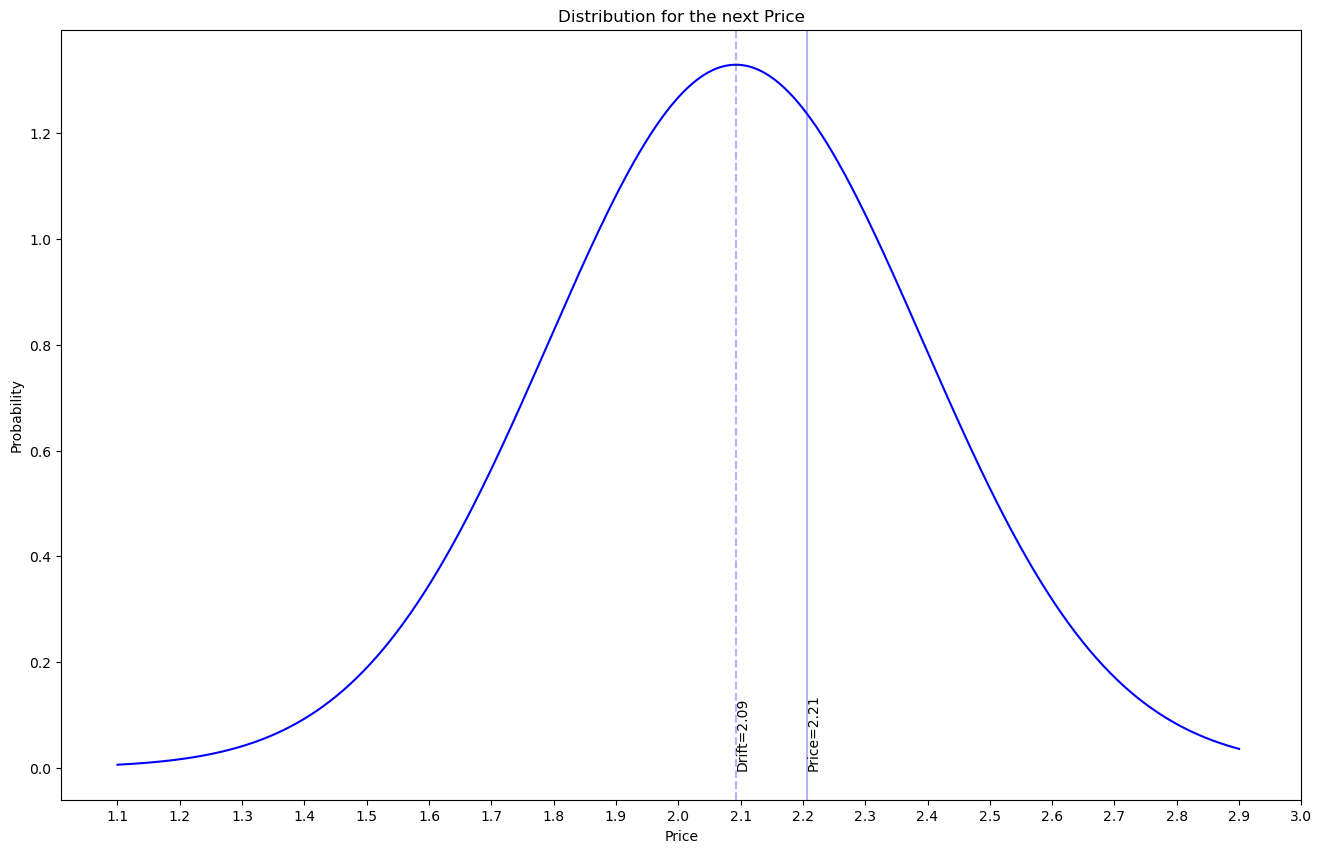

In [6]:
hi_bid = round_to(hi_latent, TICKSIZE)
hi_mid = hi_bid + TICKSIZE / 2
hi_ask = hi_bid + TICKSIZE

hi_drift = pripro.dynamics.theta * (pripro.dynamics.mu - hi_mid) * pripro.dynamics.deltat
hi_mean = hi_mid + hi_drift
std = pripro.dynamics.sigma * pripro.dynamics.deltat**0.5

prices = np.linspace(round_to(hi_mean - std * 3, TICKSIZE), round_to(hi_mean + std * 3, TICKSIZE), 1000)
pdf = stats.norm.pdf(prices, hi_mean, std)

fig, axs = plt.subplots()
axs.plot(prices, pdf, color='b')
axs.axvline(hi_mean, color='b', alpha=0.3, linestyle="--")
axs.axvline(hi_latent, color='b', alpha=0.3)

axs.text(hi_latent, 0, f"Price={hi_latent:.2f}", rotation=90)
axs.text(hi_mean, 0, f"Drift={hi_mean:.2f}", rotation=90)

xti = np.round(np.arange(prices.min(), prices.max()+TICKSIZE, TICKSIZE), 2)

axs.set(title="Distribution for the next Price", xlabel="Price", ylabel="Probability", xticks=xti, xticklabels=xti)

plt.show()

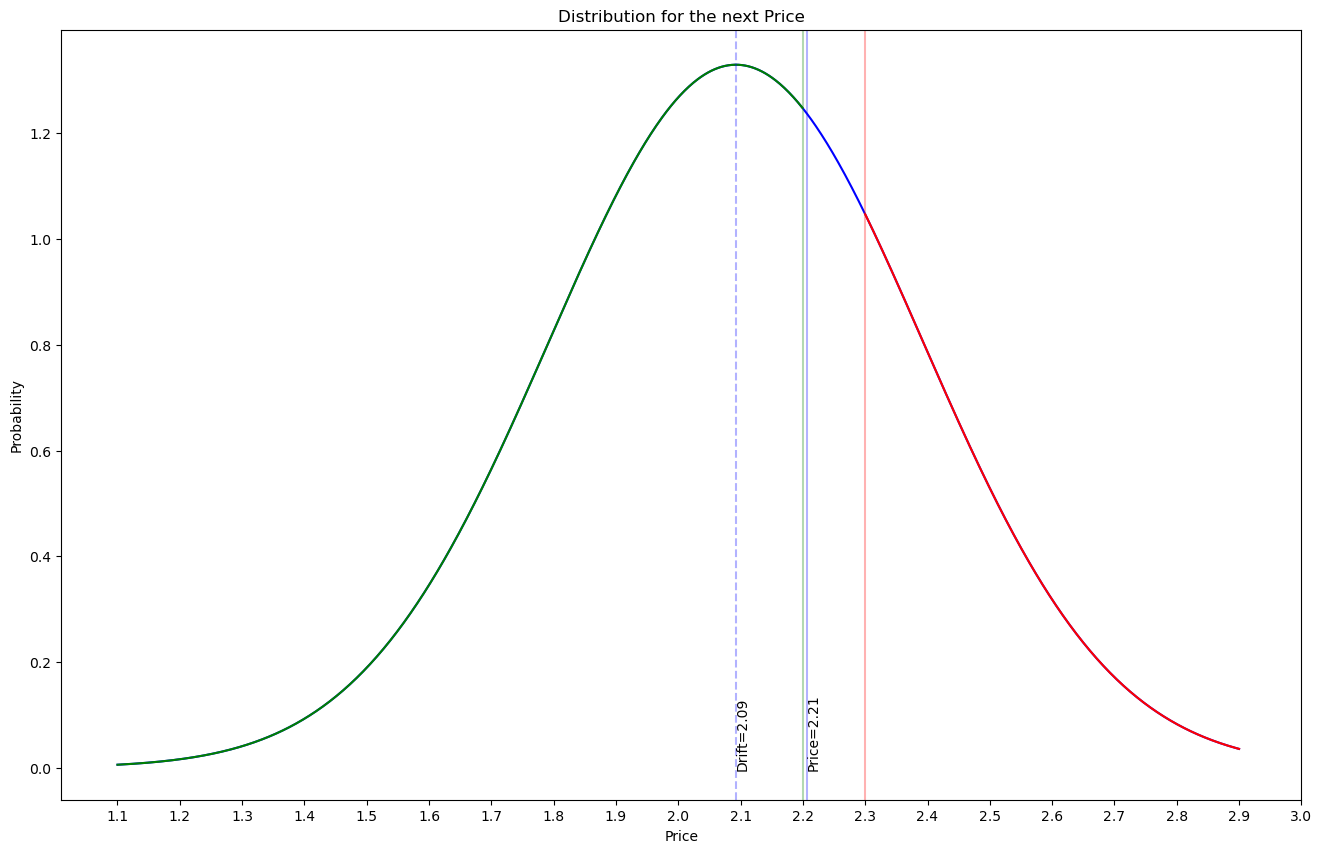

In [7]:
mask_do = prices <= hi_bid
mask_up = hi_ask <= prices

fig, axs = plt.subplots()

axs.plot(prices, pdf, color='b')
axs.plot(prices[mask_do], pdf[mask_do], color='g')
axs.plot(prices[mask_up], pdf[mask_up], color='r')
axs.axvline(hi_mean, color='b', alpha=0.3, linestyle="--")
axs.axvline(hi_latent, color='b', alpha=0.3)
axs.axvline(hi_bid, color='g', alpha=0.3)
axs.axvline(hi_ask, color='r', alpha=0.3)

axs.text(hi_latent, 0, f"Price={hi_latent:.2f}", rotation=90)
axs.text(hi_mean, 0, f"Drift={hi_mean:.2f}", rotation=90)

axs.set(title="Distribution for the next Price", xlabel="Price", ylabel="Probability", xticks=xti, xticklabels=xti)

plt.show()

In [8]:
strat = MeanRevertingStrategy(pripro, 100, 3, 1)

strat.data.loc[np.isclose(strat.data["MID"], 2.25)]

,BID,MID,ASK,EDO,EUP,PDO,PUP,TOT,KELLY,POS,N@BID,N@ASK
112,2.20,2.25,2.30,0.33,0.23,0.64,0.24,0.88,-5.28,-528.00,46.00,-44.00


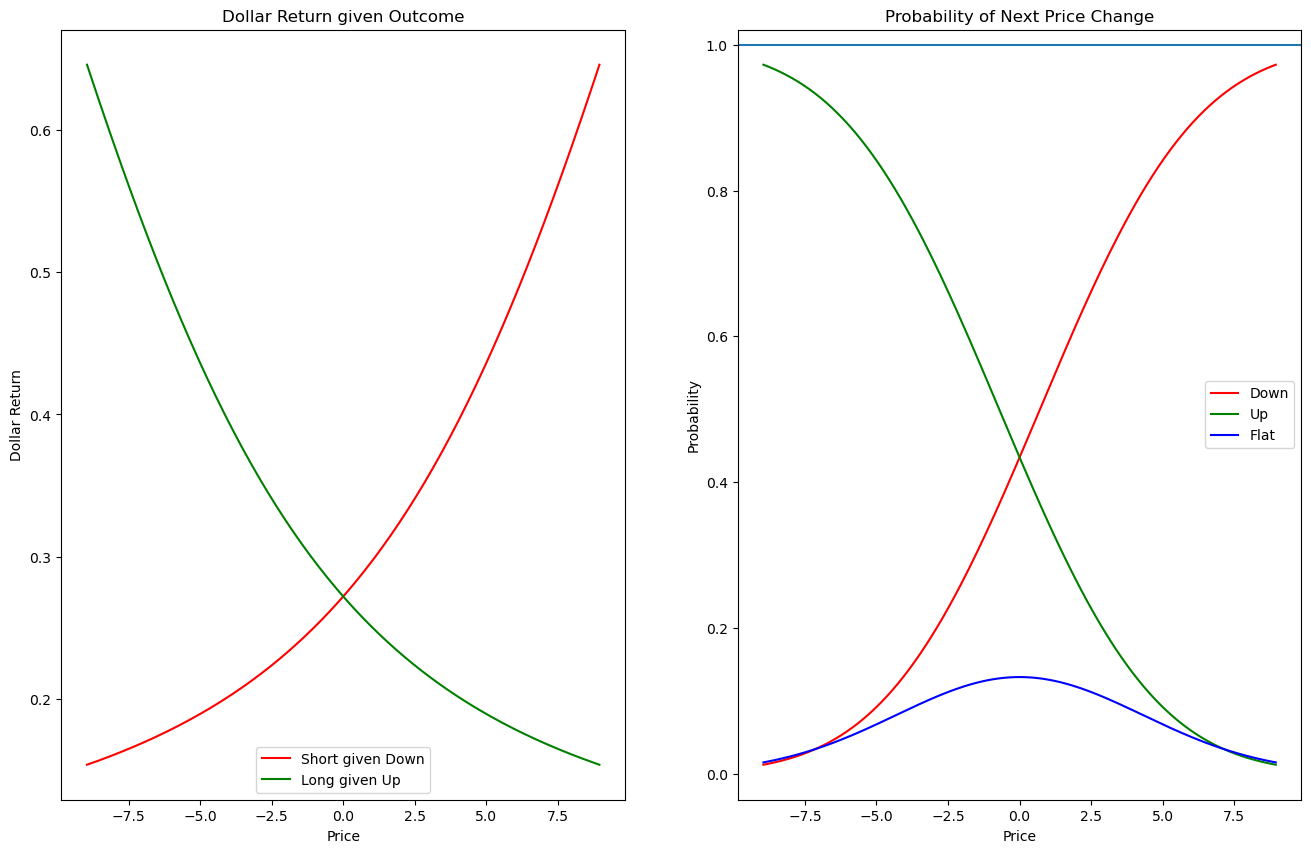

In [9]:
fig, axs = plt.subplots(1,2)

strat.plot_sizing_params(axs)

plt.show()

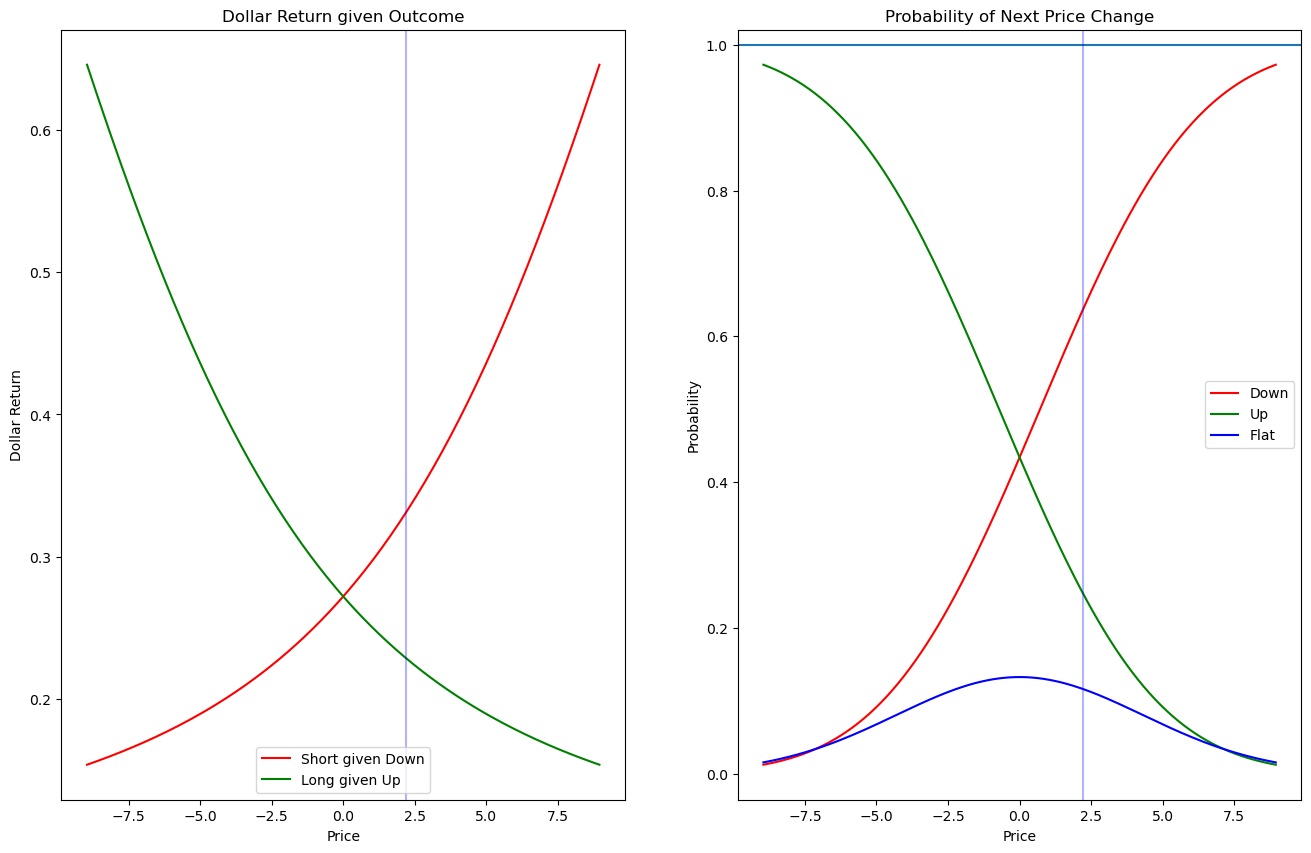

In [10]:
fig, axs = plt.subplots(1,2)

strat.plot_sizing_params(axs)

axs[0].axvline(hi_latent, color='b', alpha=0.3)
axs[1].axvline(hi_latent, color='b', alpha=0.3)

plt.show()

#### Kelly Criterion

$$
\begin{aligned}
    f^* &= \frac{p}{a} - \frac{q}{b}
\end{aligned}
$$

$p$ is the probability of a positive payoff (win).

$q=1-p$ is the probability of a negative payoff (loss).

$a$ is the payoff of a loss as a percentage return.

$b$ is the payoff of a win as a percentage return.

#### Example

We play a game with a fair coin. You must bet $100 to play and I pay you $130 if you get heads; $75 if you get tails.

$p=0.5, q=0.5, a=0.25, b=0.30 \implies f^*=0.33$

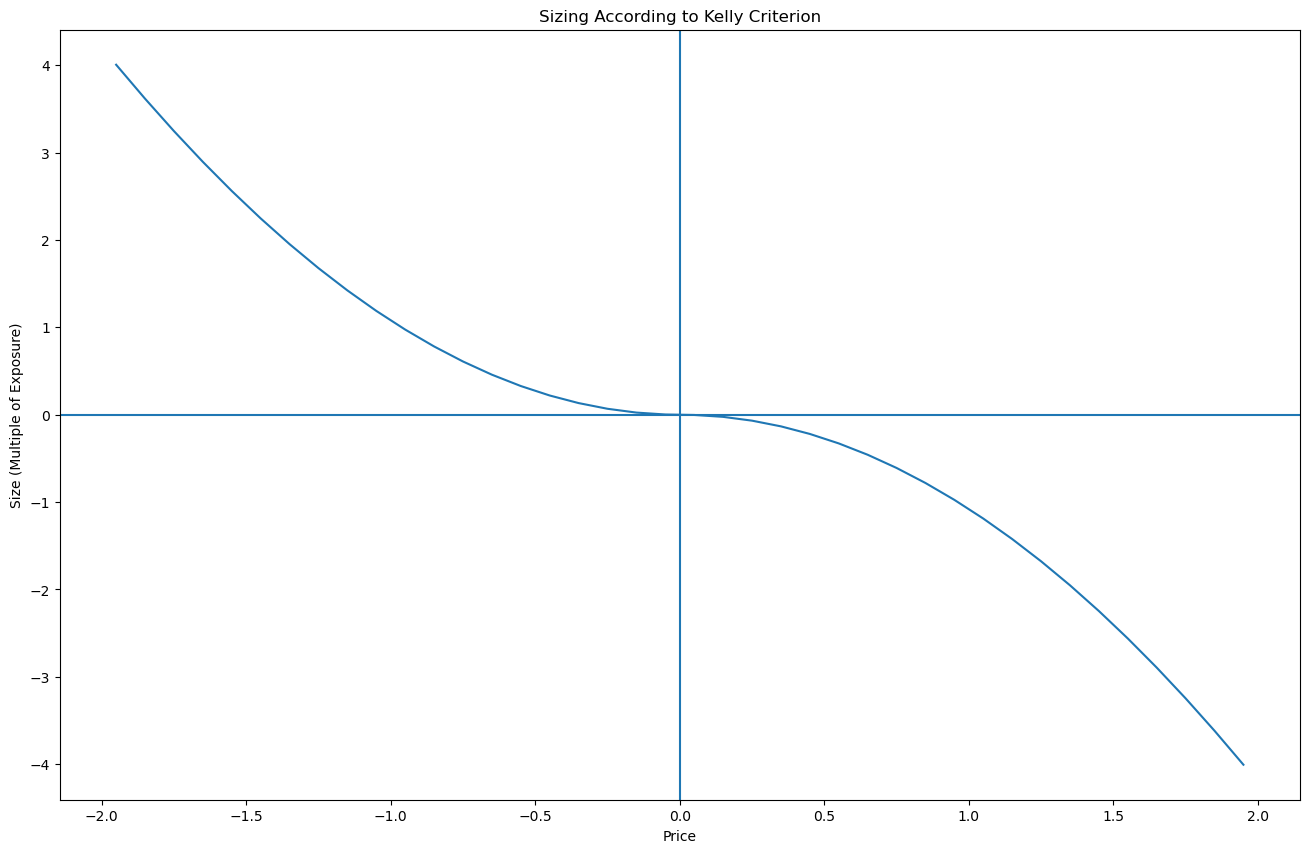

In [11]:
fig, axs = plt.subplots()

strat.plot_sizing_array(axs, np.abs(strat.data["MID"]-strat.pripro.dynamics.mu) < 2)

plt.show()

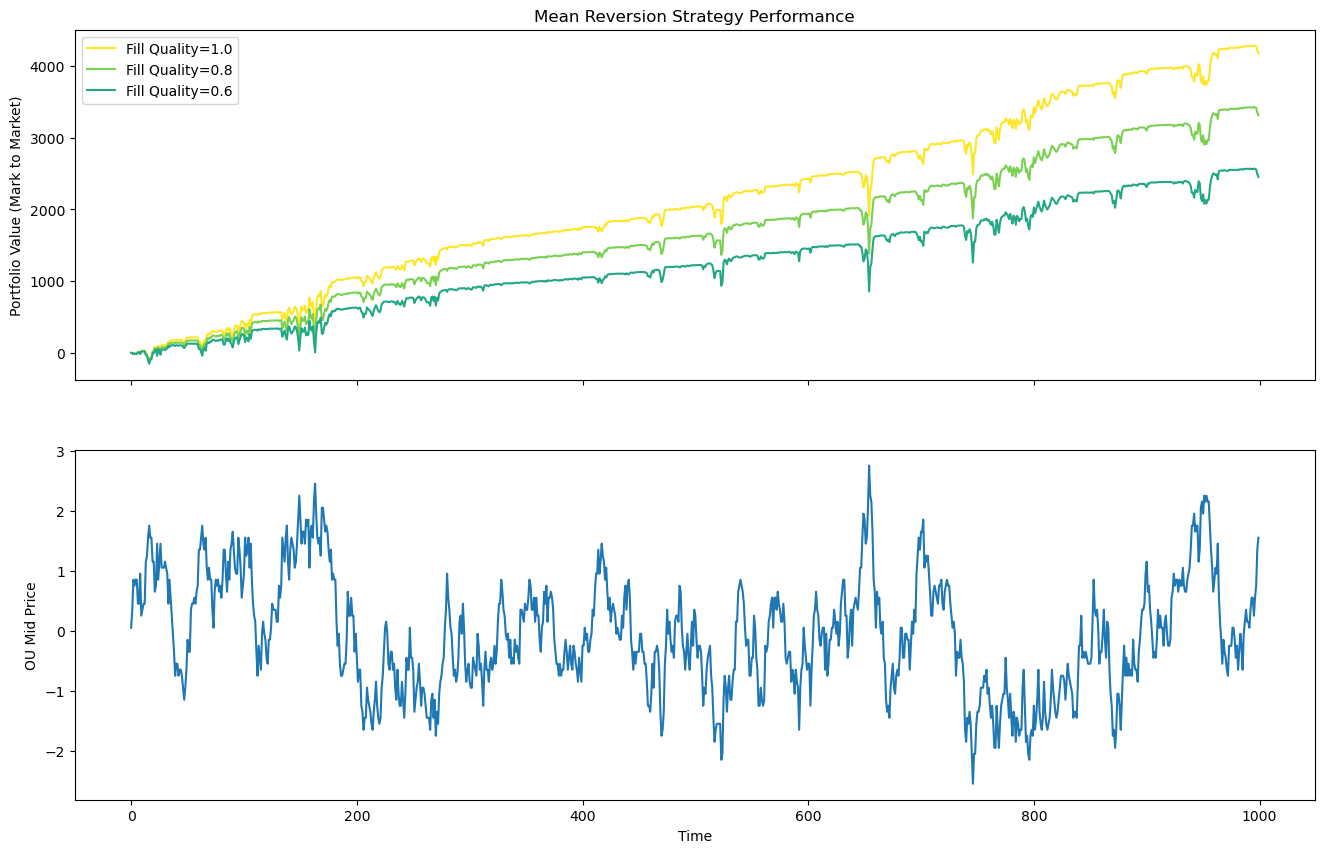

In [12]:
fig, axs = plt.subplots(2, sharex=True)

for fill in [1.0, 0.8, 0.6]:
    strat.fill_quality = fill
    strat.backtest()
    axs[0].plot(strat.trades["M2MPORT"], color=plt.cm.viridis(fill), label=f"Fill Quality={fill}")
    axs[0].set(title="Mean Reversion Strategy Performance", ylabel="Portfolio Value (Mark to Market)")
axs[0].legend()

axs[1].plot(strat.trades["MID"])
axs[1].set(xlabel="Time", ylabel="OU Mid Price")

plt.show()

In [13]:
display(strat.trades.head(3))
dat = strat.data[(0 < strat.data["MID"]) & (strat.data["MID"] < 1)]
display(dat[list(strat.data.columns[:3]) + list(strat.data.columns[-3:])])

,MID,POS,DCASH,M2MPOS,CASH,M2MPORT
0,0.05,-0.00,-0.00,-0.00,-0.00,-0.00
1,0.35,-13.00,3.78,-4.55,3.78,-0.77
2,0.85,-78.00,44.90,-66.30,48.68,-17.62


,BID,MID,ASK,POS,N@BID,N@ASK
90,-0.00,0.05,0.10,-0.00,2.00,-0.00
91,0.10,0.15,0.20,-2.00,5.00,-2.00
92,0.20,0.25,0.30,-7.00,6.00,-5.00
93,0.30,0.35,0.40,-13.00,9.00,-6.00
94,0.40,0.45,0.50,-22.00,11.00,-9.00
95,0.50,0.55,0.60,-33.00,13.00,-11.00
96,0.60,0.65,0.70,-46.00,15.00,-13.00
97,0.70,0.75,0.80,-61.00,17.00,-15.00
98,0.80,0.85,0.90,-78.00,19.00,-17.00
99,0.90,0.95,1.00,-97.00,22.00,-19.00


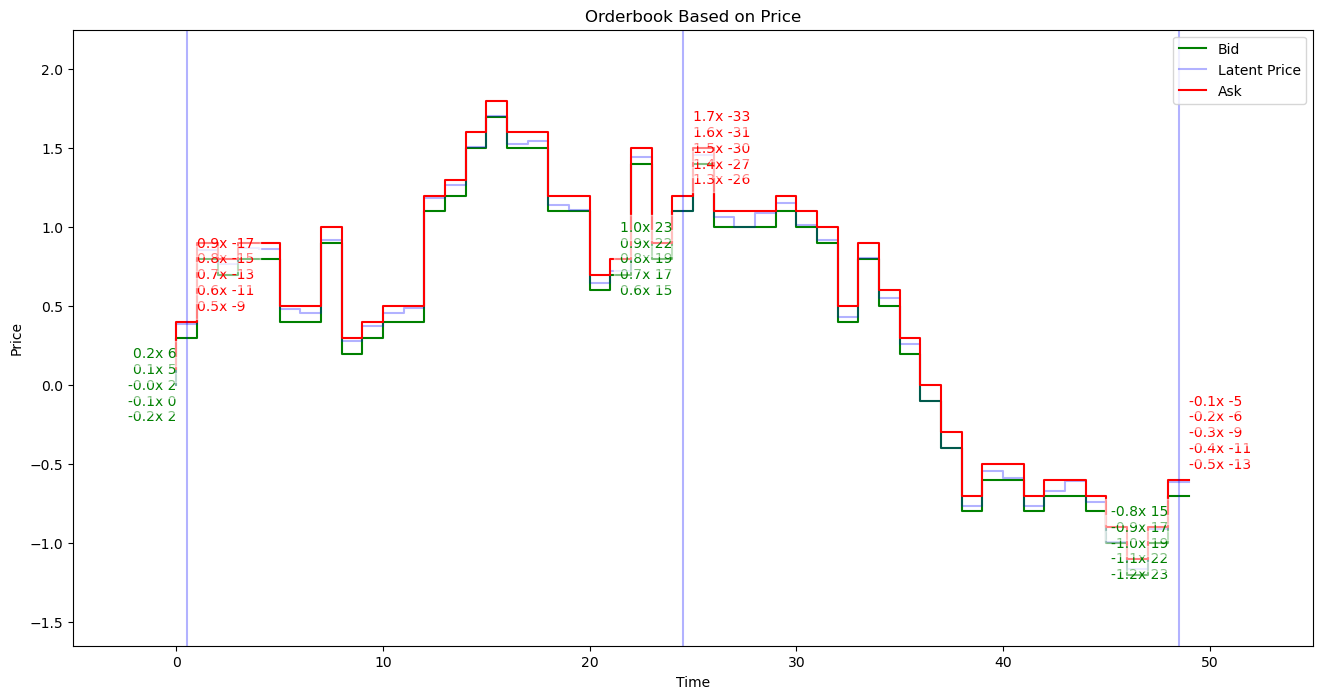

In [14]:
fig, axs = plt.subplots(figsize=(16,8))

time_end = 2*int(slice) - 1
time_mid = int(slice)
time_sta = 1
idx_end = np.argmax(np.isclose(strat.data["MID"], strat.trades.iloc[time_end]["MID"]))
idx_mid = np.argmax(np.isclose(strat.data["MID"], strat.trades.iloc[time_mid]["MID"]))
idx_sta = np.argmax(np.isclose(strat.data["MID"], strat.trades.iloc[time_sta]["MID"]))

alf = 0.5
mask = pripro.time < 2 * slice

pripro.plot_bid_ask(axs, mask)

for i, row in strat.data.iloc[idx_end+1:idx_end+6].iterrows():
    ask = row["ASK"]
    size = int(row["N@ASK"])
    txt = axs.text(time_end, ask, f"{ask:.1f}x {size}", color='r', va="center")
    txt.set_bbox(dict(facecolor='w', alpha=alf, ec='w'))
for i, row in strat.data.iloc[idx_end-5:idx_end].iterrows():
    bid = row["BID"]
    size = int(row["N@BID"])
    txt = axs.text(time_end-1, bid, f"{bid:.1f}x {size}", color='g', va="center", ha="right")
    txt.set_bbox(dict(facecolor='w', alpha=alf, ec='w'))

for i, row in strat.data.iloc[idx_mid+1:idx_mid+6].iterrows():
    ask = row["ASK"]
    size = int(row["N@ASK"])
    txt = axs.text(time_mid, ask, f"{ask:.1f}x {size}", color='r', va="center")
    txt.set_bbox(dict(facecolor='w', alpha=alf, ec='w'))
for i, row in strat.data.iloc[idx_mid-5:idx_mid].iterrows():
    bid = row["BID"]
    size = int(row["N@BID"])
    txt = axs.text(time_mid-1, bid, f"{bid:.1f}x {size}", color='g', va="center", ha="right")
    txt.set_bbox(dict(facecolor='w', alpha=alf, ec='w'))

for i, row in strat.data.iloc[idx_sta+1:idx_sta+6].iterrows():
    ask = row["ASK"]
    size = int(row["N@ASK"])
    txt = axs.text(time_sta, ask, f"{ask:.1f}x {size}", color='r', va="center")
    txt.set_bbox(dict(facecolor='w', alpha=alf, ec='w'))
for i, row in strat.data.iloc[idx_sta-5:idx_sta].iterrows():
    bid = row["BID"]
    size = int(row["N@BID"])
    txt = axs.text(time_sta-1, bid, f"{bid:.1f}x {size}", color='g', va="center", ha="right")
    txt.set_bbox(dict(facecolor='w', alpha=alf, ec='w'))

axs.axvline(time_end-0.5, color='b', alpha=0.3)
axs.axvline(time_mid-0.5, color='b', alpha=0.3)
axs.axvline(time_sta-0.5, color='b', alpha=0.3)
axs.set(title="Orderbook Based on Price", xlim=[-5, 2 * slice + 5], 
        ylim=[strat.trades.loc[mask, "MID"].min() - 5*strat.pripro.ticksize,
              strat.trades.loc[mask, "MID"].max() + 5*strat.pripro.ticksize])

plt.show()

In [15]:
dat["ASK"].values[1:4] @ dat["N@ASK"].values[1:4]

-4.2999999999995735

In [16]:
dat["ASK"].values[4:9] @ dat["N@ASK"].values[4:9]

-47.49999999999777